# Performance benchmark

The aim of this notebook is to compare different elasticsearch settings in terms of performance and quality of results (closeness to ground truth).

## Variables to fine-tune
We establish the following values for different elasticsearch settings:

1. Number of shards: 1, 3, 6, 12
2. Max num segments: 1 (optimal for read-only indices)
3. Query: We take as base query the mediawiki query (most complete, slow), and perform the following modifications to it:
    * [`base`] No modification
    * [`no-rescoring`] Skip rescoring
    * [`no-plain`] Restrict to non-plain fields
    * [`restrict-4`] Restrict to title, text, opening_text and heading
    * [`restrict-2`] Restrict to title and text
   
   These modifications are independent (e.g. there is rescoring in `no-plain` and plain fields are used in `restrict-4`)

## Data

The data with which the benchmark will be carried out is composed of keywords in course descriptions, for which we know the relevant wikipage from manual tagging.

A random subset of keywords will be selected every time to prevent caching at both elasticsearch level and file system level.

## Procedure

For each setting (i.e. choice of (number_of_shards, query)), we will randomly select *n* keywords from the course descriptions, then run both a wikipedia api request and an elasticsearch request for each of them. We will keep track of the execution time and we will evaluate the quality of the results by checking whether the manually-tagged page associated to the keywords is contained in the list of results.

## Disclaimer

All requests will be directed to the graph-ai-test server, which runs elasticsearch on a regular HDD. Replacing that with an SDD might improve performance presumably 5 to 10-fold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unicodedata

from interfaces.es import ES
from interfaces.wp import WP
from interfaces.db import DB

from concept_detection.text.utils import normalize

from concept_detection.time.stopwatch import Stopwatch
from utils.progress_bar import ProgressBar

from concept_detection.test.courses.compare import *

## Initialization

We instantiate the interfaces to communicate with the database and the wikipedia api.

In [3]:
db = DB()
wp = WP()

We define the grids of values for each variable and the interfaces to communicate with elasticsearch.

In [4]:
queries = ['restrict-2', 'restrict-4', 'no-plain', 'no-rescoring', 'base']

es = {12: ES('wikipages'), 6: ES('wikipages_6_shards'), 3: ES('wikipages_3_shards'), 1: ES('wikipages_1_shards')}
shards = list(es.keys())

We also set several constants that we will use later.

In [5]:
batch_size = 100    # number of keywords per setting
random_seed = 7     # seed for randomness

We finally initialize a variable to hold all results of the execution, so that we can analyze them later.

In [6]:
results = []

## Ground truth

We obtain the ground truth keywords to pages

In [7]:
wikified_course_descriptions = db.query_wikified_course_descriptions()
ground_truth = pd.DataFrame([(normalize(result.keywords), result.page_id, result.page_title) for course_id in wikified_course_descriptions for result in wikified_course_descriptions[course_id]], columns=['Keywords', 'PageID', 'PageTitle'])

ground_truth

,Keywords,PageID,PageTitle
0,architectural,12319895,Architectural_firm
1,architectural production,21296224,Architecture
2,architectural thinking,7217678,Enterprise_Architecture_Body_of_Knowledge
3,architecture,25596555,Lego_Architecture
4,casts,1006266,Plaster_cast
...,...,...,...
29162,voice,38481,Human_voice
29163,architectures,25652303,Computer_architecture
29164,distributed architectures,8501,Distributed_computing
29165,information systems,237495,Information_system


Also we need the ids of all pages in the database so we can filter them in the computation of the recall. Otherwise we might penalize elasticsearch for not finding pages **not present** in the database.

In [8]:
db_page_ids = db.get_wikipage_ids()

## Helper functions

The following function processes a batch of keywords in a given setting and returns a list of the results.

In [9]:
def es_search(query, shard):
    if query == 'base':
        return es[shard].search_mediawiki
    if query == 'no-rescoring':
        return es[shard].search_mediawiki_no_rescore
    if query == 'no-plain':
        return es[shard].search_mediawiki_no_plain
    if query == 'restrict-4':
        return es[shard].search_mediawiki_restrict_4
    if query == 'restrict-2':
        return es[shard].search_mediawiki_restrict_2

In [10]:
def process_batch(batch, query, shard):
    sw = Stopwatch()
    
    batch_results = []
    for index, row in batch.iterrows():
        keywords = row['Keywords']
        
        sw.reset()
        wp_results = wp.search(keywords)
        wp_time = sw.delta()
        
        sw.reset()
        es_results = es_search(query, shard)(keywords)
        es_time = sw.delta()
        
        wp_page_ids = set(r.page_id for r in wp_results if r.page_id in db_page_ids)
        es_page_ids = set(r.page_id for r in es_results)
        gt_page_ids = {row['PageID']}
        
        es_wp_recall = len(es_page_ids & wp_page_ids) / len(wp_page_ids) if wp_page_ids else 1
        es_gt_recall = len(es_page_ids & gt_page_ids) / len(gt_page_ids) if gt_page_ids else 1
        wp_gt_recall = len(wp_page_ids & gt_page_ids) / len(gt_page_ids) if gt_page_ids else 1
        
        results.append([query, shard, wp_time, es_time, es_wp_recall, es_gt_recall, wp_gt_recall])
    
    return batch_results

## Execution

In [11]:
pb = ProgressBar(len(queries) * len(shards))
for shard in shards:
    for query in queries:
        batch = ground_truth.sample(batch_size)
        batch_results = process_batch(batch, query, shard)
        results.extend(batch_results)
        pb.update()

[##################################################] 100.00%


## Results

We gather the results in a DataFrame to make their interpretation easier.

In [12]:
results_df = pd.DataFrame(results, columns=['query', 'shards', 'wp_time', 'es_time', 'es_wp_recall', 'es_gt_recall', 'wp_gt_recall'])
results_df['es_wp_time_ratio'] = results_df['es_time'] / results_df['wp_time']
results_df['es_recall_time_ratio'] = results_df['es_gt_recall'] / results_df['es_time']
results_df['wp_recall_time_ratio'] = results_df['wp_gt_recall'] / results_df['wp_time']

results_df = results_df.sort_values(by=['query', 'shards'])

results_df.head()

,query,shards,wp_time,es_time,es_wp_recall,es_gt_recall,wp_gt_recall,es_wp_time_ratio,es_recall_time_ratio,wp_recall_time_ratio
1900,base,1,0.362766,0.657353,0.200000,1.0,1.0,1.812059,1.521252,2.756600
1901,base,1,0.357938,1.554424,0.600000,1.0,1.0,4.342721,0.643325,2.793781
1902,base,1,0.373005,0.413465,0.700000,1.0,1.0,1.108470,2.418584,2.680928
1903,base,1,0.329024,0.486228,0.555556,1.0,1.0,1.477788,2.056648,3.039291
1904,base,1,0.361885,0.902626,0.600000,1.0,1.0,2.494234,1.107879,2.763308


We create other DataFrames with results aggregated by method, number of shards and query type.

In [13]:
method_gp = results_df.groupby(['query', 'shards'], as_index=False).mean()
method_gp['method'] = method_gp['query'] + '-' + method_gp['shards'].map(str).str.zfill(2) + '-shards'

method_gp

,query,shards,wp_time,es_time,es_wp_recall,es_gt_recall,wp_gt_recall,es_wp_time_ratio,es_recall_time_ratio,wp_recall_time_ratio,method
0,base,1,0.384161,0.593705,0.531738,0.83,0.98,1.574158,2.018384,2.664960,base-01-shards
1,base,3,0.413132,0.428088,0.518020,0.80,0.96,1.051356,2.552321,2.449122,base-03-shards
2,base,6,0.356192,0.500747,0.560377,0.83,0.95,1.402262,2.237527,2.693875,base-06-shards
3,base,12,0.355286,0.504228,0.566210,0.86,0.97,1.418074,2.223594,2.758262,base-12-shards
4,no-plain,1,0.360359,0.654698,0.558671,0.80,0.95,1.796003,1.810690,2.678807,no-plain-01-shards
5,no-plain,3,0.378884,0.513456,0.538865,0.81,0.93,1.401985,2.047148,2.610277,no-plain-03-shards
6,no-plain,6,0.375583,0.501561,0.521075,0.81,0.96,1.366112,2.253061,2.667634,no-plain-06-shards
7,no-plain,12,0.377527,0.548922,0.531671,0.89,0.99,1.498476,2.191236,2.730487,no-plain-12-shards
8,no-rescoring,1,0.379646,0.537391,0.476687,0.85,0.97,1.432112,2.091991,2.616798,no-rescoring-01-shards
9,no-rescoring,3,0.380355,0.338192,0.467948,0.91,0.98,0.931869,3.650493,2.704355,no-rescoring-03-shards


In [14]:
shard_gp = method_gp.drop('query', axis=1).groupby('shards', as_index=False).mean()

shard_gp

,shards,wp_time,es_time,es_wp_recall,es_gt_recall,wp_gt_recall,es_wp_time_ratio,es_recall_time_ratio,wp_recall_time_ratio
0,1,0.375764,0.693643,0.517776,0.820,0.966,1.837286,1.668374,2.634908
1,3,0.382305,0.516850,0.516294,0.844,0.968,1.382473,2.309300,2.645296
2,6,0.365953,0.499677,0.508787,0.836,0.964,1.374728,2.397222,2.699509
3,12,0.366044,0.510528,0.516575,0.826,0.970,1.399096,2.362931,2.705596


In [15]:
query_gp = method_gp.drop('shards', axis=1).groupby('query', as_index=False).mean()

query_gp

,query,wp_time,es_time,es_wp_recall,es_gt_recall,wp_gt_recall,es_wp_time_ratio,es_recall_time_ratio,wp_recall_time_ratio
0,base,0.377193,0.506692,0.544086,0.8300,0.9650,1.361462,2.257957,2.641555
1,no-plain,0.373088,0.554659,0.537570,0.8275,0.9575,1.515644,2.075534,2.671801
2,no-rescoring,0.376399,0.384739,0.472310,0.8375,0.9550,1.036603,3.128877,2.620703
3,restrict-2,0.373887,0.727399,0.522284,0.8400,0.9700,1.923569,1.605802,2.648624
4,restrict-4,0.362016,0.602384,0.498042,0.8225,0.9875,1.654701,1.854114,2.773954


We finally produce several plots to visualize the results from different angles and draw conclusions. The following is a helper function to encapsulate the plot generation.

In [16]:
def plot_results(x, y, labels, title, xlabel, ylabel):
    fig, ax = plt.subplots(dpi=120)

    for i in range(len(y)):
        ax.plot(x, y[i], label=labels[i], marker='.', alpha=0.8)

    plt.xticks(rotation=45, ha='right')
    ax.set_ylim(0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid()
    ax.set_title(title)
    
    if len(x) == 20:
        ax.vlines([3.5, 7.5, 11.5, 15.5], -10, 10, color='gray', alpha=0.5)
        ax.text(1.5, 0.2, 'mediawiki', color='gray', alpha=0.5, ha='center', va='center')
        ax.text(5.5, 0.2, 'skip plain\nfields', color='gray', alpha=0.5, ha='center', va='center')
        ax.text(9.5, 0.2, 'skip\nrescoring', color='gray', alpha=0.5, ha='center', va='center')
        ax.text(13.5, 0.2, 'only\ntitle\ntext', color='gray', alpha=0.5, ha='center', va='center')
        ax.text(17.5, 0.2, 'only\ntitle\ntext\nheading\nopening_text', color='gray', alpha=0.5, ha='center', va='center')

In [17]:
def box_plot_results(y, labels, title, xlabel, ylabel):
    fig, ax = plt.subplots(dpi=120)

    ax.boxplot(y, labels=labels)
    
    plt.xticks(rotation=45, ha='right')
    ax.set_ylim(0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_title(title)

#### Average time

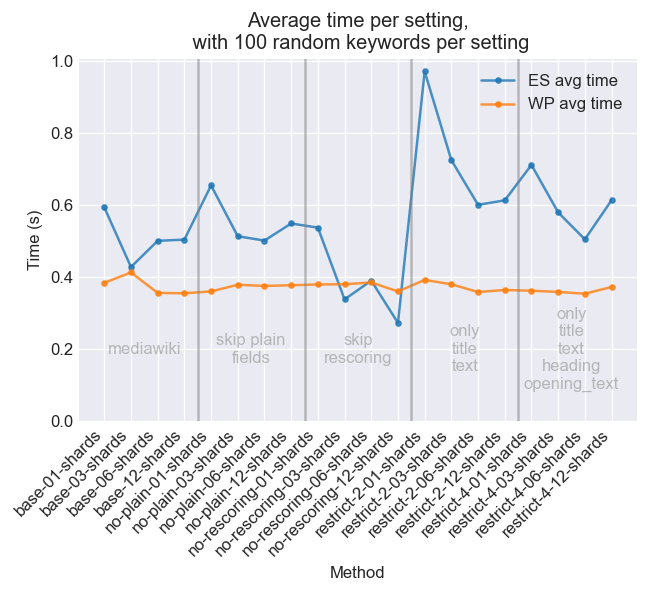

In [18]:
x = method_gp['method']
y = [method_gp['es_time'], method_gp['wp_time']]
labels = ['ES avg time', 'WP avg time']
title=f'Average time per setting,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Method', ylabel='Time (s)')

#### Average time aggregated by shards

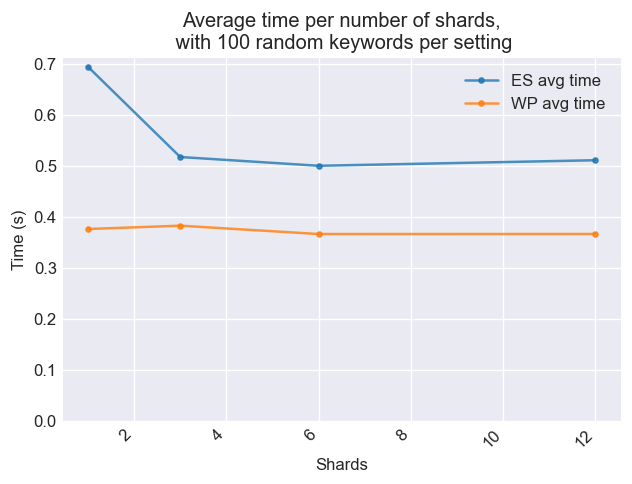

In [19]:
x = shard_gp['shards']
y = [shard_gp['es_time'], shard_gp['wp_time']]
labels = ['ES avg time', 'WP avg time']
title=f'Average time per number of shards,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Shards', ylabel='Time (s)')

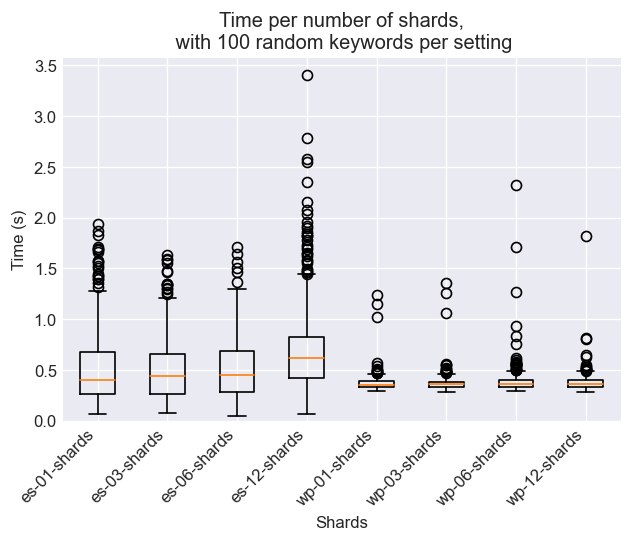

In [20]:
y = [results_df.query(f'shards == {shard}')[f'{how}_time'] for how in ['es', 'wp'] for shard in shards]
labels = [f'{how}-{str(shard).zfill(2)}-shards' for how in ['es', 'wp'] for shard in reversed(shards)]
title=f'Time per number of shards,\n with {batch_size} random keywords per setting'
box_plot_results(y=y, labels=labels, title=title, xlabel='Shards', ylabel='Time (s)')

#### Average time aggregated by query

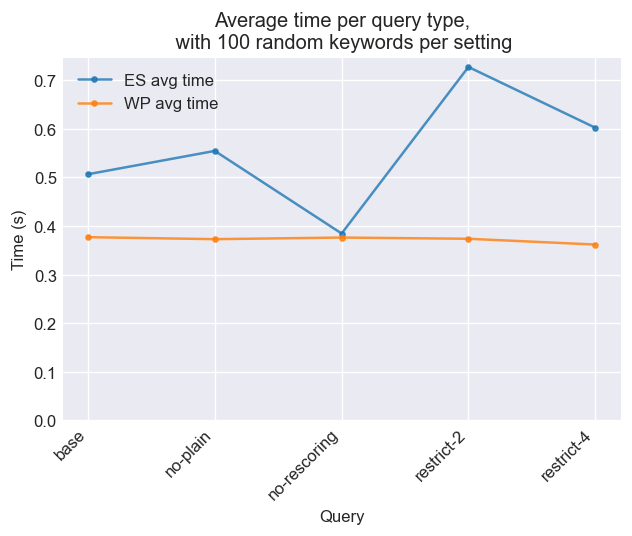

In [21]:
x = query_gp['query']
y = [query_gp['es_time'], query_gp['wp_time']]
labels = ['ES avg time', 'WP avg time']
title=f'Average time per query type,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Query', ylabel='Time (s)')

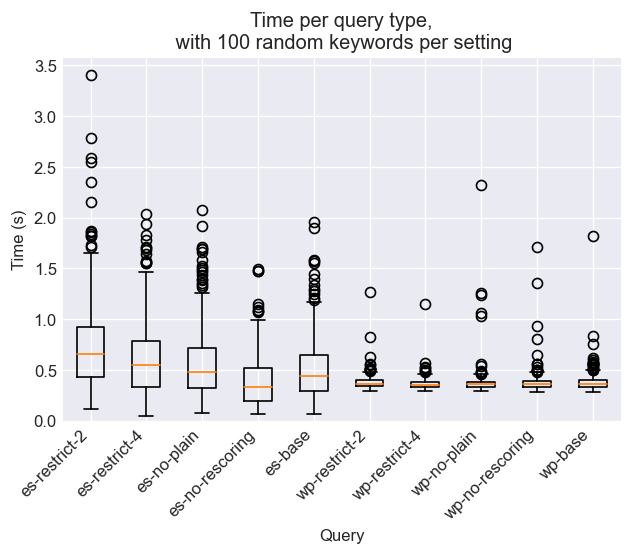

In [22]:
y = [results_df.query(f'query == "{query}"')[f'{how}_time'] for how in ['es', 'wp'] for query in queries]
labels = [f'{how}-{query}' for how in ['es', 'wp'] for query in queries]
title=f'Time per query type,\n with {batch_size} random keywords per setting'
box_plot_results(y=y, labels=labels, title=title, xlabel='Query', ylabel='Time (s)')

#### Average recall

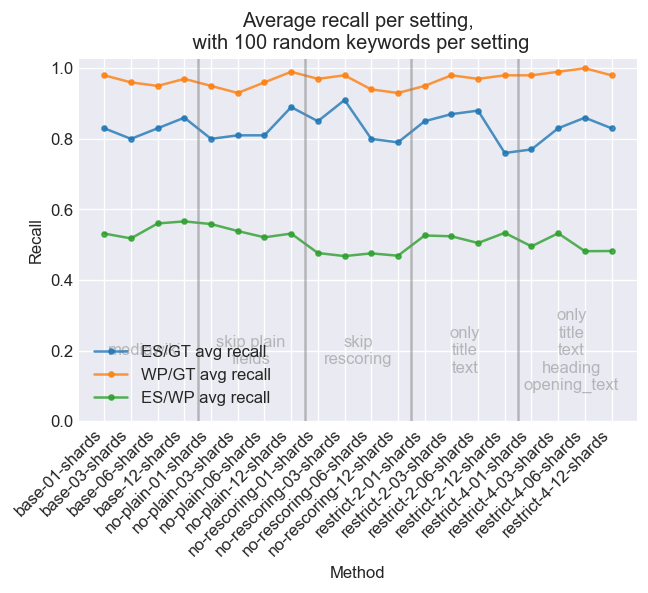

In [23]:
x = method_gp['method']
y = [method_gp['es_gt_recall'], method_gp['wp_gt_recall'], method_gp['es_wp_recall']]
labels = ['ES/GT avg recall', 'WP/GT avg recall', 'ES/WP avg recall']
title=f'Average recall per setting,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Method', ylabel='Recall')

#### Average recall aggregated by shards

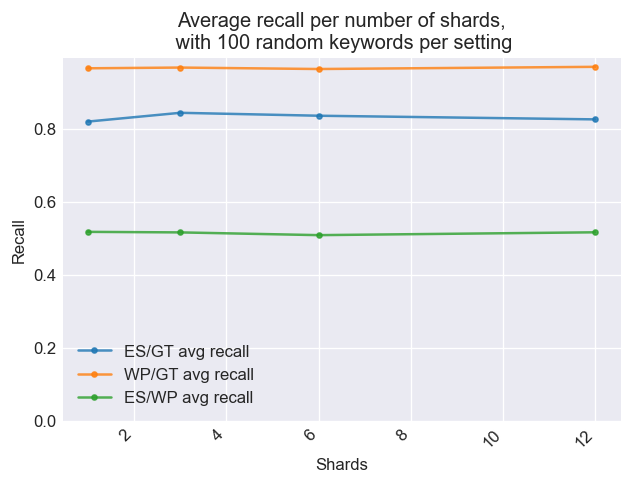

In [24]:
x = shard_gp['shards']
y = [shard_gp['es_gt_recall'], shard_gp['wp_gt_recall'], shard_gp['es_wp_recall']]
labels = ['ES/GT avg recall', 'WP/GT avg recall', 'ES/WP avg recall']
title=f'Average recall per number of shards,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Shards', ylabel='Recall')

In [32]:
y = [results_df.query(f'shards == {shard}')[f'{how}_gt_recall'] for how in ['es', 'wp'] for shard in shards]
labels = [f'{how}-{shard}-shards' for how in ['es', 'wp'] for shard in shards]
title=f'Recall per number of shards,\n with {batch_size} random keywords per setting'
# box_plot_results(y=y, labels=labels, title=title, xlabel='Shards', ylabel='Recall')

#### Average recall aggregated by query

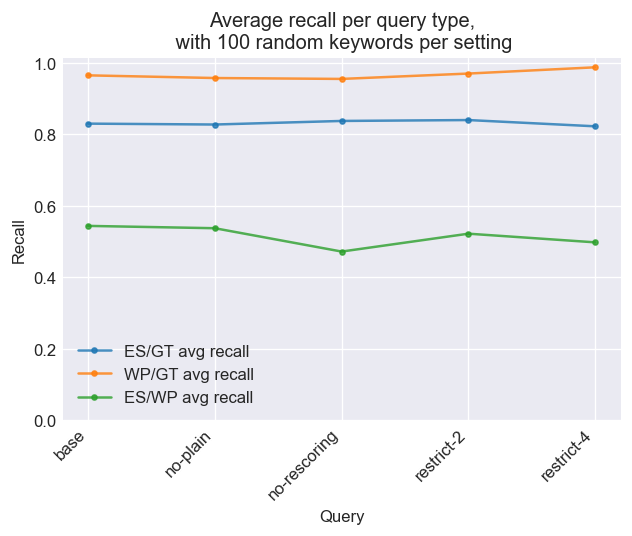

In [26]:
x = query_gp['query']
y = [query_gp['es_gt_recall'], query_gp['wp_gt_recall'], query_gp['es_wp_recall']]
labels = ['ES/GT avg recall', 'WP/GT avg recall', 'ES/WP avg recall']
title=f'Average recall per query type,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Query', ylabel='Recall')

In [33]:
y = [results_df.query(f'query == "{query}"')[f'{how}_gt_recall'] for how in ['es', 'wp'] for query in queries]
labels = [f'{how}-{query}' for how in ['es', 'wp'] for query in queries]
title=f'Recall per query type,\n with {batch_size} random keywords per setting'
# box_plot_results(y=y, labels=labels, title=title, xlabel='Query', ylabel='Recall')

#### Average ES/WP time ratio

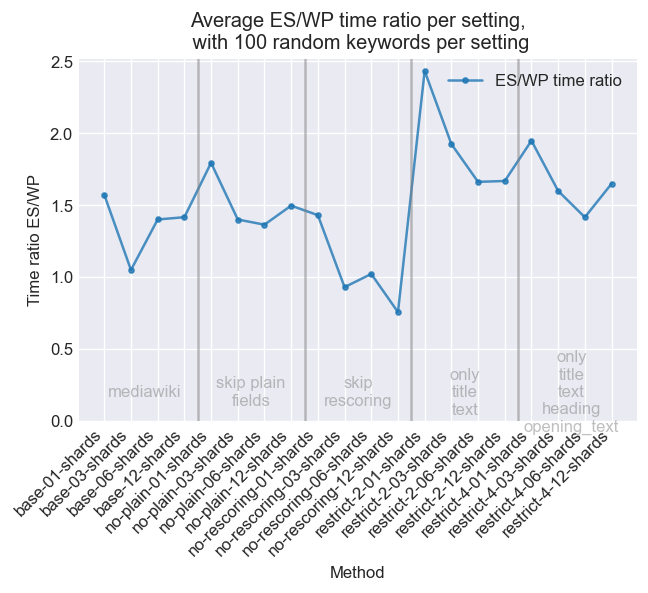

In [28]:
x = method_gp['method']
y = [method_gp['es_wp_time_ratio']]
labels = ['ES/WP time ratio']
title=f'Average ES/WP time ratio per setting,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Method', ylabel='Time ratio ES/WP')

#### Average recall/time ratio

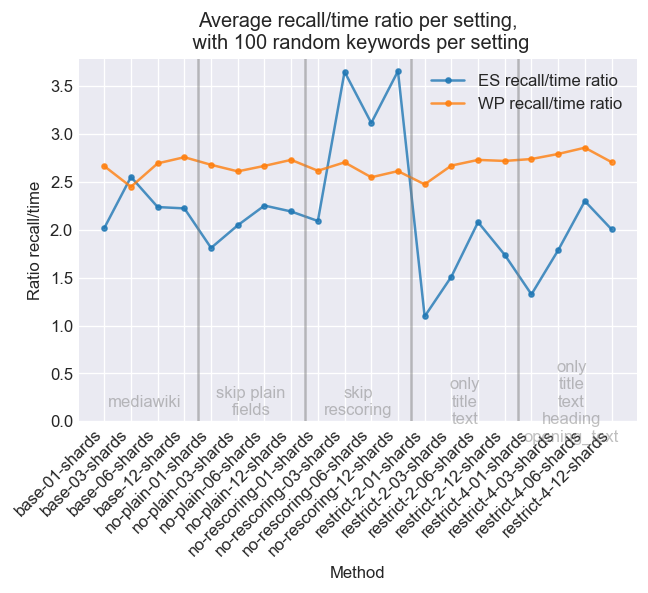

In [29]:
x = method_gp['method']
y = [method_gp['es_recall_time_ratio'], method_gp['wp_recall_time_ratio']]
labels = ['ES recall/time ratio', 'WP recall/time ratio']
title=f'Average recall/time ratio per setting,\n with {batch_size} random keywords per setting'

plot_results(x=x, y=y, labels=labels, title=title, xlabel='Method', ylabel='Ratio recall/time')